In [1]:
import gc
import logging
import os
import glob
import pandas as pd

import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')


import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from math import exp

import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

num = 10

/home/vikrant/core/home/R/goal/baselines/deep_prediction/argoverse-api/argoverse/map_representation/map_api.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lane_polygons = np.array(self.get_vector_map_lane_polygons(city_name))
/home/vikrant/core/home/R/goal/baselines/deep_prediction/argoverse-api/argoverse/map_representation/map_api.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  driveable_areas = np.array(self.get_vector_map_driveable_areas(city_name))


In [2]:
import os
import sys
sys.path.append("../ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
#from bernstein import bernstesin_coeff_order10_new

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

def denoise(gt_x, gt_y, w = 7):
    # denoising
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x)):
        if iq >= w and iq + w <= len(gt_x):
            gt_x_t.append(np.mean(gt_x[iq: iq + w]))
            gt_y_t.append(np.mean(gt_y[iq: iq + w]))
        elif iq < w:
            okx = np.mean(gt_x[w: w + w])
            gt_x_t.append(gt_x[0] + (okx - gt_x[0]) * (iq) / w)
            oky = np.mean(gt_y[w: w + w])
            gt_y_t.append(gt_y[0] + (oky - gt_y[0]) * (iq) / w)
        else:
            okx = np.mean(gt_x[len(gt_x) - w:len(gt_x) - w  + w])
            oky = np.mean(gt_y[len(gt_x) - w: len(gt_x) - w + w])
            gt_x_t.append(okx + (gt_x[-1] - okx) * (w - (len(gt_x) - iq)) / w)
            gt_y_t.append(oky + (gt_y[-1] - oky) * (w - (len(gt_y) - iq)) / w)                   

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y

def uniform_sample(gt_x, gt_y, w = 7):
    # denoising
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x) - w + 1):
        gt_x_t.append(np.mean(gt_x[iq: iq + w]))
        gt_y_t.append(np.mean(gt_y[iq: iq + w]))

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y


def rotate(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y

def transform(x_traj, y_traj, dt = 0.3, t_obs = 20, theta=None, offsets=None):
    if offsets == None:
        x_traj -= x_traj[0]
        y_traj -= y_traj[0]
    else:
        x_traj -= offsets[0]
        y_traj -= offsets[1]
        
    gt_x = x_traj
    gt_y = y_traj
    
    gt_x, gt_y = denoise(gt_x, gt_y)
    v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
    v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
    psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  

    # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)

    # obtain this -psi
    if theta == None:
        theta = -psi[t_obs - 1]

    # rotate by theta
    gt_x, gt_y = rotate(gt_x, gt_y, theta)
    v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
    v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
    psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]
    psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
    psi_traj = [i.item() for i in psi]
    psidot_traj = [i.item() for i in psidot]
    
    return gt_x, gt_y, v_x, v_y, psi, psidot, psi_traj, psidot_traj, theta

In [3]:
random_colors = np.random.rand(100,3)

In [4]:
import inspect
def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]
retrieve_name(random_colors)

'random_colors'

In [5]:
import os
import sys
sys.path.append("../../ddn/")
sys.path.append("../../")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader


def bernstein_coeff_order10_new(n, tmin, tmax, t_actual):
    l = tmax - tmin
    t = (t_actual - tmin) / l

    P0 = scipy.special.binom(n, 0) * ((1 - t) ** (n - 0)) * t ** 0
    P1 = scipy.special.binom(n, 1) * ((1 - t) ** (n - 1)) * t ** 1
    P2 = scipy.special.binom(n, 2) * ((1 - t) ** (n - 2)) * t ** 2
    P3 = scipy.special.binom(n, 3) * ((1 - t) ** (n - 3)) * t ** 3
    P4 = scipy.special.binom(n, 4) * ((1 - t) ** (n - 4)) * t ** 4
    P5 = scipy.special.binom(n, 5) * ((1 - t) ** (n - 5)) * t ** 5
    P6 = scipy.special.binom(n, 6) * ((1 - t) ** (n - 6)) * t ** 6
    P7 = scipy.special.binom(n, 7) * ((1 - t) ** (n - 7)) * t ** 7
    P8 = scipy.special.binom(n, 8) * ((1 - t) ** (n - 8)) * t ** 8
    P9 = scipy.special.binom(n, 9) * ((1 - t) ** (n - 9)) * t ** 9
    P10 = scipy.special.binom(n, 10) * ((1 - t) ** (n - 10)) * t ** 10

    P0dot = -10.0 * (-t + 1) ** 9
    P1dot = -90.0 * t * (-t + 1) ** 8 + 10.0 * (-t + 1) ** 9
    P2dot = -360.0 * t ** 2 * (-t + 1) ** 7 + 90.0 * t * (-t + 1) ** 8
    P3dot = -840.0 * t ** 3 * (-t + 1) ** 6 + 360.0 * t ** 2 * (-t + 1) ** 7
    P4dot = -1260.0 * t ** 4 * (-t + 1) ** 5 + 840.0 * t ** 3 * (-t + 1) ** 6
    P5dot = -1260.0 * t ** 5 * (-t + 1) ** 4 + 1260.0 * t ** 4 * (-t + 1) ** 5
    P6dot = -840.0 * t ** 6 * (-t + 1) ** 3 + 1260.0 * t ** 5 * (-t + 1) ** 4
    P7dot = -360.0 * t ** 7 * (-t + 1) ** 2 + 840.0 * t ** 6 * (-t + 1) ** 3
    P8dot = 45.0 * t ** 8 * (2 * t - 2) + 360.0 * t ** 7 * (-t + 1) ** 2
    P9dot = -10.0 * t ** 9 + 9 * t ** 8 * (-10.0 * t + 10.0)
    P10dot = 10.0 * t ** 9

    P0ddot = 90.0 * (-t + 1) ** 8
    P1ddot = 720.0 * t * (-t + 1) ** 7 - 180.0 * (-t + 1) ** 8
    P2ddot = 2520.0 * t ** 2 * (-t + 1) ** 6 - 1440.0 * t * (-t + 1) ** 7 + 90.0 * (-t + 1) ** 8
    P3ddot = 5040.0 * t ** 3 * (-t + 1) ** 5 - 5040.0 * t ** 2 * (-t + 1) ** 6 + 720.0 * t * (-t + 1) ** 7
    P4ddot = 6300.0 * t ** 4 * (-t + 1) ** 4 - 10080.0 * t ** 3 * (-t + 1) ** 5 + 2520.0 * t ** 2 * (-t + 1) ** 6
    P5ddot = 5040.0 * t ** 5 * (-t + 1) ** 3 - 12600.0 * t ** 4 * (-t + 1) ** 4 + 5040.0 * t ** 3 * (-t + 1) ** 5
    P6ddot = 2520.0 * t ** 6 * (-t + 1) ** 2 - 10080.0 * t ** 5 * (-t + 1) ** 3 + 6300.0 * t ** 4 * (-t + 1) ** 4
    P7ddot = -360.0 * t ** 7 * (2 * t - 2) - 5040.0 * t ** 6 * (-t + 1) ** 2 + 5040.0 * t ** 5 * (-t + 1) ** 3
    P8ddot = 90.0 * t ** 8 + 720.0 * t ** 7 * (2 * t - 2) + 2520.0 * t ** 6 * (-t + 1) ** 2
    P9ddot = -180.0 * t ** 8 + 72 * t ** 7 * (-10.0 * t + 10.0)
    P10ddot = 90.0 * t ** 8
    90.0 * t ** 8

    P = np.hstack((P0, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10))
    Pdot = np.hstack((P0dot, P1dot, P2dot, P3dot, P4dot, P5dot, P6dot, P7dot, P8dot, P9dot, P10dot)) / l
    Pddot = np.hstack((P0ddot, P1ddot, P2ddot, P3ddot, P4ddot, P5ddot, P6ddot, P7ddot, P8ddot, P9ddot, P10ddot)) / (l ** 2)
    return P, Pdot, Pddot

class OPTNode(nn.Module):
    def __init__(self, rho_eq=1.0, rho_goal=1.0, rho_nonhol=1.0, rho_psi=1.0, maxiter=5000, weight_smoothness=1.0, weight_smoothness_psi=1.0, t_fin=2.0, num=30, bernstein_coeff_order10_new=None, device="cpu"):
        super().__init__()
        self.rho_eq = rho_eq
        self.rho_goal = rho_goal
        self.rho_nonhol = rho_nonhol
        self.rho_psi = rho_psi
        self.maxiter = maxiter
        self.weight_smoothness = weight_smoothness
        self.weight_smoothness_psi = weight_smoothness_psi
        self.bernstein_coeff_order10_new = bernstein_coeff_order10_new
        
        self.device = device
        
        self.t_fin = t_fin
        self.num = num
        self.t = self.t_fin / self.num

        #self.num_batch = 10
        
        tot_time = np.linspace(0.0, self.t_fin, self.num)
        tot_time_copy = tot_time.reshape(self.num, 1)
        self.P, self.Pdot, self.Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
        self.nvar = np.shape(self.P)[1]
        
        self.cost_smoothness = self.weight_smoothness * np.dot(self.Pddot.T, self.Pddot)
        self.cost_smoothness_psi = self.weight_smoothness_psi * np.dot(self.Pddot.T, self.Pddot)
        self.lincost_smoothness_psi = np.zeros(self.nvar)

        self.A_eq = np.vstack((self.P[0], self.P[-1]))
        self.A_eq_psi = np.vstack((self.P[0], self.Pdot[0], self.P[-1]))
        
        # self.P = torch.tensor(self.P, dtype=torch.double).to(device)
        # self.Pdot = torch.tensor(self.Pdot, dtype=torch.double).to(device)
        # self.Pddot = torch.tensor(self.Pddot, dtype=torch.double).to(device)
        # self.A_eq = torch.tensor(self.A_eq, dtype=torch.double).to(device)        
        # self.A_eq_psi = torch.tensor(self.A_eq_psi, dtype=np.double).to(device)
        # self.cost_smoothness = np.tensor(self.cost_smoothness, dtype=np.double).to(device)
        # self.cost_smoothness_psi = np.tensor(self.cost_smoothness_psi, dtype=np.double).to(device)
        # self.lincost_smoothness_psi = np.tensor(self.lincost_smoothness_psi, dtype=np.double).to(device)
    
        self.A_nonhol = self.Pdot
        self.A_psi = self.P
        
        self.lamda_x = None
        self.lamda_y = None
        self.lamda_psi = None
        
    def compute_x(self, v, psi, b_eq_x, b_eq_y):
        b_nonhol_x = v * np.cos(psi)
        b_nonhol_y = v * np.sin(psi)
    
        cost = self.cost_smoothness + self.rho_nonhol * np.dot(self.A_nonhol.T, self.A_nonhol) + self.rho_eq * np.dot(self.A_eq.T, self.A_eq)
        lincost_x = -self.lamda_x - self.rho_nonhol * np.dot(self.A_nonhol.T, b_nonhol_x.T).T - self.rho_eq * np.dot(self.A_eq.T, b_eq_x.T).T
        lincost_y = -self.lamda_y - self.rho_nonhol * np.dot(self.A_nonhol.T, b_nonhol_y.T).T - self.rho_eq * np.dot(self.A_eq.T, b_eq_y.T).T

        cost_inv = np.linalg.inv(cost)

        sol_x = np.dot(-cost_inv, lincost_x.T).T
        sol_y = np.dot(-cost_inv, lincost_y.T).T

        x = np.dot(self.P, sol_x.T).T
        xdot = np.dot(self.Pdot, sol_x.T).T

        y = np.dot(self.P, sol_y.T).T
        ydot = np.dot(self.Pdot, sol_y.T).T
         
        return sol_x, sol_y, x, xdot, y, ydot
    
    def compute_psi(self, psi, lamda_psi, psi_temp, b_eq_psi):
        cost = self.cost_smoothness_psi + self.rho_psi * np.dot(self.A_psi.T, self.A_psi) + self.rho_eq * np.dot(self.A_eq_psi.T, self.A_eq_psi)
        lincost_psi = -self.lamda_psi - self.rho_psi * np.dot(self.A_psi.T, psi_temp.T).T - self.rho_eq * np.dot(self.A_eq_psi.T, b_eq_psi.T).T

        cost_inv = np.linalg.inv(cost)

        sol_psi = np.dot(-cost_inv, lincost_psi.T).T

        psi = np.dot(self.P, sol_psi.T).T

        res_psi = np.dot(self.A_psi, sol_psi.T).T - psi_temp
        res_eq_psi = np.dot(self.A_eq_psi, sol_psi.T).T - b_eq_psi

        self.lamda_psi = self.lamda_psi - self.rho_psi * np.dot(self.A_psi.T, res_psi.T).T - self.rho_eq * np.dot(self.A_eq_psi.T, res_eq_psi.T).T

        return sol_psi, np.linalg.norm(res_psi), np.linalg.norm(res_eq_psi), psi

    
    def solve(self, fixed_params, variable_params):
        batch_size, _ = fixed_params.shape
        x_init, y_init, v_init, psi_init, psidot_init = np.split(fixed_params, 5, axis=1)
        x_fin, y_fin, psi_fin = np.split(variable_params, 3, axis=1)
        
        b_eq_x = np.concatenate((x_init, x_fin), axis=1)
        b_eq_y = np.concatenate((y_init, y_fin), axis=1)
        b_eq_psi = np.concatenate((psi_init, psidot_init, psi_fin), axis=1)
        
        v = np.ones((batch_size, self.num)) * v_init
        psi = np.ones((batch_size, self.num)) * psi_init
        xdot = v * np.cos(psi)
        ydot = v * np.sin(psi)
        
        self.lamda_x = np.zeros((batch_size, self.nvar))
        self.lamda_y = np.zeros((batch_size, self.nvar))
        self.lamda_psi = np.zeros((batch_size, self.nvar))
        
        res_psi_arr = []
        res_eq_psi_arr = []
        res_eq_arr = []
        res_nonhol_arr = []
        for i in range(0, self.maxiter):
            psi_temp = np.arctan2(ydot, xdot)
            c_psi, res_psi, res_eq_psi, psi = self.compute_psi(psi, self.lamda_psi, psi_temp, b_eq_psi)
            c_x, c_y, x, xdot, y, ydot = self.compute_x(v, psi, b_eq_x, b_eq_y)
            
            res_eq_psi_arr.append(res_eq_psi)
            res_psi_arr.append(res_psi)
            v = np.sqrt(xdot ** 2 + ydot ** 2)
            #v[:, 0] = v_init[:, 0]

            res_eq_x = np.dot(self.A_eq, c_x.T).T - b_eq_x
            res_nonhol_x = xdot - v * np.cos(psi)

            res_eq_y = np.dot(self.A_eq, c_y.T).T - b_eq_y
            res_nonhol_y = ydot - v * np.sin(psi)

            res_eq_arr.append(np.linalg.norm(np.sqrt(res_eq_x**2 + res_eq_y**2)))
            res_nonhol_arr.append(np.linalg.norm(np.sqrt(res_nonhol_x**2 + res_nonhol_y**2)))
            
            self.lamda_x = self.lamda_x - self.rho_eq * np.dot(self.A_eq.T, res_eq_x.T).T - self.rho_nonhol * np.dot(self.A_nonhol.T, res_nonhol_x.T).T
            self.lamda_y = self.lamda_y - self.rho_eq * np.dot(self.A_eq.T, res_eq_y.T).T - self.rho_nonhol * np.dot(self.A_nonhol.T, res_nonhol_y.T).T
        
        primal_sol = np.hstack((c_x, c_y, c_psi, v))
        return primal_sol, None
    
    def objective(self, fixed_params, variable_params, y):
        c_x = y[:, :self.nvar]
        c_y = y[:, self.nvar:2*self.nvar]
        c_psi = y[:, 2*self.nvar:3*self.nvar]
        v = y[:, 3*self.nvar:]
        
        x_init, y_init, v_init, psi_init, psidot_init = np.split(fixed_params, 5, axis=1)
        x_fin, y_fin, psi_fin = np.split(variable_params, 3, axis=1)
        
        x = np.dot(self.P, c_x.T).T
        y = np.dot(self.P, c_y.T).T
        psi = np.dot(self.P, c_psi.T).T
        xdot = np.dot(self.Pdot, c_x.T).T
        ydot = np.dot(self.Pdot, c_y.T).T
        psidot = np.dot(self.Pdot, c_psi.T).T
        xddot = np.dot(self.Pddot, c_x.T).T
        yddot = np.dot(self.Pddot, c_y.T).T
        psiddot = np.dot(self.Pddot, c_psi.T).T
        
        cost_nonhol = 0.5*self.rho_nonhol*np.sum((xdot - v*np.cos(psi)) ** 2, 1) + 0.5*self.rho_nonhol*np.sum((ydot - v*np.sin(psi)) ** 2, 1)
        cost_pos = 0.5*self.rho_eq*(np.sum((x[:, -1] - x_fin) ** 2, 1) + np.sum((y[:, -1] - y_fin) ** 2, 1) + np.sum((x[:, 0] - x_init) ** 2, 1) + np.sum((y[:, 0] - y_init) ** 2, 1))
        cost_psi = 0.5*self.rho_eq*(np.sum((psi[:, -1] - psi_fin) ** 2, 1) + np.sum((psi[:, 0] - psi_init) ** 2, 1)
                                    + np.sum((psidot[:, 0] - psidot_init) ** 2, 1))
        #cost_v = 0.5*self.rho_eq*np.sum((v[:, 0] - v_init) ** 2, 1)
        cost_cancel = np.diagonal(np.dot(-self.lamda_x, c_x.T) + np.dot(-self.lamda_y, c_y.T) + np.dot(-self.lamda_psi, c_psi.T))
        
        cost_smoothness = 0.5*self.weight_smoothness*(np.sum(xddot**2, 1) + np.sum(yddot**2, 1)) + 0.5*self.weight_smoothness_psi*np.sum(psiddot**2, 1)
        return cost_nonhol + cost_pos + cost_psi + cost_smoothness + cost_cancel #+ cost_v 

In [6]:
t_fin = 3
num = 30
problem = OPTNode(rho_eq=1.0, rho_goal=1.0, rho_nonhol=1.0, rho_psi=1.0, maxiter=5000, weight_smoothness=1.0, weight_smoothness_psi=1.0, t_fin=t_fin, num=15, bernstein_coeff_order10_new=bernstein_coeff_order10_new, device="cpu")

In [62]:
import random
import networkx as nx
import sklearn
from shapely.geometry.polygon import Polygon, Point
data_path="/home/vikrant/datasets/datasets/argoverse/val/data"
output_dir="../results/"
t_obs=20
dt=0.3
t_obs=20
pred=False
pred_array=None
batch_size = 512
dpi=100
w,h=512,512
res=0.5
paths = glob.glob(os.path.join(data_path, "*.csv"))
print(paths[0])
to_viz = False
trajs = []
color = {
    'polygon': '#e6cf93',
    'polygon-outline': '#e6cf93',
    'centerline': '#fceec7',
    'agent': 'blue',
    'av': 'grey',
    'other': 'grey',
    'outline': 'black'
}
color_modes = {
    'left_forks': '#ffffcc',
    'right_forks': 'grey',
    'left_lane_change': 'red',
    'right_lane_change': 'orange',
    'holds': 'green',
    'other': 'grey'
}

numss = []

data_path="/home/vikrant/datasets/datasets/argoverse/val/data"
order = np.load('../data/order.npy')
from tqdm import tqdm

data_augmented = []

total_centerlines = []

for idx in tqdm(range(len(paths))):
    fil = order[idx].split('/')[-1]
    path = data_path + "/" + fil
    dff = pd.read_csv(path)
    
    city = dff['CITY_NAME'].values[0]    
    
    agent_df = dff[dff['OBJECT_TYPE'] == 'AGENT']
    x_a = agent_df['X'].values
    y_a = agent_df['Y'].values    
    x_a, y_a = denoise(x_a, y_a)
    
    theta_init = np.arctan2(y_a[20] - y_a[19], x_a[20] - x_a[19])
    x_rotated, y_rotated = rotate(x_a - x_a[0], y_a - y_a[0], -theta_init)
    
    gt_x = agent_df['X'].values
    gt_y = agent_df['Y'].values

    x_max, y_max = np.max(gt_x) + 100, np.max(gt_y) + 100
    x_min, y_min = np.min(gt_x) - 100, np.min(gt_y) - 100    
    
    # group by timestamp
    dfs = [x for _, x in dff.groupby('TIMESTAMP')]    
    
    total_successors = []
    current = []
    das_polygons = []
    das_polygons_mp = []
    das_ids = []

    agent_polygons = []    
    dic = {}
    G = nx.DiGraph()
    cur = None
    
    color_map = []
#     print(color_mapping)


    orderr = {}
    traj_path = {}
    curr_order = 0    

    try: 
        os.mkdir("modes/{}".format(idx))
    except:
        pass    

    #########################################################################    
    ##################### BUILDING GRAPH ####################################
    #########################################################################
    
    for indd in range(0, 20):
        lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
        if indd == 19:
            cur = lane_id        
        lneigh, rneigh = avm.get_lane_segment_adjacent_ids(lane_segment_id=lane_id, city_name=city)[0], avm.get_lane_segment_adjacent_ids(lane_segment_id=lane_id, city_name=city)[1]
        ids = [lane_id, lneigh, rneigh]
        dic[lane_id] = 0
        if lneigh != None: 
            G.add_node(lneigh)
            dic[lneigh] = -1
            G.add_edge(lane_id, lneigh)
        if rneigh != None: 
            G.add_node(rneigh)
            dic[rneigh] = -1
            G.add_edge(lane_id, rneigh)
        for idd in ids:
            if idd == None:
                continue
            lane_id = idd
            current.append(lane_id)
            successors = avm.get_lane_segment_successor_ids(lane_id, city)
            if successors == None:
                continue
            if dic.get(lane_id) == None:
                G.add_node(lane_id)
            for successor in successors:
                if dic.get(successor) == None:
                    dic[successor] = 1
                    G.add_node(successor)
                G.add_edge(lane_id, successor)            
                total_successors.append(successor)
                successors_2d = avm.get_lane_segment_successor_ids(successor, city)
                if successors_2d == None:
                    continue                 
                for successorr in successors_2d:
                    if dic.get(successorr) == None:
                        dic[successorr] = 2
                        G.add_node(successorr)
                    G.add_edge(successor, successorr)                                     
                    total_successors.append(successorr)    

    #########################################################################
    #########################################################################
    #########################################################################
    
    
    
    
    #########################################################################    
    ##################### PERFORMING BFS ####################################
    #########################################################################
    prev_lane = None
    for indd in range(0, 20):
        lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
        prev_lane = lane_id
        traj_path[lane_id] = 1
        if orderr.get(lane_id) == None: orderr[lane_id] = curr_order # traversed
        lneigh, rneigh = avm.get_lane_segment_adjacent_ids(lane_segment_id=lane_id, city_name=city)[0], avm.get_lane_segment_adjacent_ids(lane_segment_id=lane_id, city_name=city)[1]
        ids = [lane_id, lneigh, rneigh]
        for idd in ids:
            if idd == None:
                continue
            orderr[idd] = orderr[lane_id]                
            lane_id = idd
            successors = avm.get_lane_segment_successor_ids(lane_id, city)
            if successors == None:
                continue
            for successor in successors:
                if orderr.get(successor) == None:
                    orderr[successor] = orderr[lane_id] + 1
                successors_2d = avm.get_lane_segment_successor_ids(successor, city)
                if successors_2d == None:
                    continue
                for successorr in successors_2d:
                    if orderr.get(successorr) == None:
                        orderr[successorr] = orderr[lane_id] + 2
    
    leaves = []
    heads = []
    paths = {}
    for ind, node in enumerate(G.nodes):
        if G.in_degree[node] == 1 and G.out_degree[node] == 0:
            leaves.append(node)
        if orderr[node] == 0:
            heads.append(node)
            paths[node] = -1

    for head in heads:
        # start bfs from here
        flag = True
        queue = []
        queue.append(head)
        while len(queue):
            start = queue.pop(0)
            for node in G.neighbors(start):
#                 if G.has_edge(head)
                if orderr[node] > orderr[start]:
                    if paths.get(node) == None:
                        paths[node] = start
                    queue.append(node)
        
    #########################################################################
    #########################################################################
    #########################################################################


    
    #########################################################################    
    ################## CLASSIFYING TRAJECTORIES #############################
    #########################################################################
    left_forks = []
    right_forks = []
    left_lane_change = []
    right_lane_change = []
    holds = []
    init_len = len(trajs)  
    types = {}
    seq = []
    for indd in range(20, 50):
        lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
        dic[lane_id] = 3 # traversed
    for indd in range(0, 20):
        lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
        dic[lane_id] = 0 # traversed                

    for leafno, leaf in enumerate(leaves):
        # go above
        cnttt = 0
        lane_id = leaf
        path = []
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            x_plot, y_plot = arr[:, 0], arr[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        while paths.get(lane_id) != None and cnttt < 100:
            cnttt = cnttt + 1
            polygon = avm.get_lane_segment_polygon(lane_id, city)
            x_plot, y_plot = polygon[:, 0], polygon[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            path.append(lane_id)
            if paths.get(lane_id) != None:
                lane_id = paths[lane_id]
        seq.append(path)
        if len(path) == 0: continue
        centerline = avm.get_lane_segment_centerline(path[0], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        angle = np.arctan2(cy - y_rotated[20], cx - x_rotated[20]) - np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        if abs(angle + np.pi) < np.pi/6: continue # U turn ignored
        if cur in path:
            if angle < -np.pi/3:
                right_forks.append(path)
                for p in path: types[p] = 1
            elif angle > np.pi/3:
                left_forks.append(path)
                for p in path: types[p] = -1
            else:
                holds.append(path)
                for p in path: types[p] = 0                
        else:
            is_neigh = False
            for indd in range(0, 20):
                lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
                lneigh, rneigh = avm.get_lane_segment_adjacent_ids(lane_segment_id=lane_id, city_name=city)[0], avm.get_lane_segment_adjacent_ids(lane_segment_id=lane_id, city_name=city)[1]
                if rneigh in path:
                    left_lane_change.append(path)
                    centerline = avm.get_lane_segment_centerline(path[0], city)
                    x_plot, y_plot = centerline[:, 0], centerline[:, 1]
                    x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
                    cx, cy = x_plot[-1], y_plot[-1]
                    angle = np.arctan2(cy - y_rotated[20], cx - x_rotated[20]) - np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
                    if angle > -np.pi/2 and angle < np.pi/2:
                        for p in path: types[p] = -2
                        break
                elif lneigh in path:
                    right_lane_change.append(path)
                    if angle < np.pi/2 and angle > -np.pi/2:
                        for p in path: types[p] = 2
                        break

        centerline = avm.get_lane_segment_centerline(path[1], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
        v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
        psidot_init = (psi_init_1 - psi_init)/0.1
        psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
        var_inp = np.array([cx, cy, psi_fin])
        fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
        var_inp = np.array([cx, cy, psi_fin])

        sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

        tot_time = np.linspace(0.0, t_fin, num)
        tot_time_copy = tot_time.reshape(num, 1)

        P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

        nvar = 11
        x_pred = np.dot(P, sol[:, :nvar].T)
        y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
        x_pred = x_pred.T
        y_pred = y_pred.T

        if abs(angle + np.pi) > np.pi/6:
            x_final = np.concatenate((x_rotated[:20], x_pred[0]))
            y_final = np.concatenate((y_rotated[:20], y_pred[0]))
            trajs.append(np.concatenate((x_final.reshape(50, 1), y_final.reshape(50, 1)), axis=1))
    #########################################################################
    #########################################################################
    #########################################################################


    
    #########################################################################    
    ####################### PLOTTING GT #####################################
    #########################################################################
        
    if to_viz: plt.figure(figsize=(30,15))
    if to_viz: plt.subplot(1, 2, 1) # row 1, col 2 index 1
        
    x_off = 75
    y_off = 75
    points = np.array([[x_a[20] - x_off, y_a[20] + y_off],[x_a[20] + x_off, y_a[20] + y_off], [x_a[20] + x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] + y_off]])

    gt_x = agent_df['X'].values
    gt_y = agent_df['Y'].values

    x_max, y_max = np.max(gt_x) + 100, np.max(gt_y) + 100
    x_min, y_min = np.min(gt_x) - 100, np.min(gt_y) - 100
    
    for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
        x_plot, y_plot = arr[:, 0], arr[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
        if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)
    
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    lane_centerlines = []        
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline
        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)
    
    for lane_cl in lane_centerlines:
        x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
        if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)
        
    x_traj = agent_df['X'].values
    y_traj = agent_df['Y'].values
#     x_a, y_a = x_rotated, y_rotated
    x_traj, y_traj = x_rotated, y_rotated
    if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)
    if to_viz: plt.scatter(x_traj[t_obs:], y_traj[t_obs:], color='orange', label='GT', zorder=5)

        
    current = np.unique(np.array(current))
    total_successors = np.unique(np.array(total_successors))    
    color_mapping = {}
    polygon_mapping = {}
    inddd = 0
    for curr in current:
        current_polygon = avm.get_lane_segment_polygon(curr, city)
        das_polygons.append(current_polygon)
        das_polygons_mp.append(avm.get_lane_segment_polygon(curr, city))
        das_ids.append(curr)
        node = curr
        if types.get(node) == None:
            color = 'white'
            continue
        if types[node] == 0:
            color = 'green'
        elif types[node] == -1:
            color = '#ffffcc'
        elif types[node] == 1:
            color = 'grey'
        elif types[node] == 2:
            color = 'orange'
        else:
            color = 'red'
        inddd = inddd + 1
        color_here = color
        x_plot, y_plot = current_polygon[:, 0], current_polygon[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        if to_viz: plt.fill(x_plot, y_plot, color=color_here, zorder=4)
        color_mapping[curr] = color_here
        polygon_mapping[curr] = current_polygon
    for successor in total_successors : 
        polygon = avm.get_lane_segment_polygon(successor, city)
        das_polygons.append(polygon)
        das_polygons_mp.append(avm.get_lane_segment_polygon(successor, city))
        das_ids.append(successor)
        node = successor
        if types.get(node) == None:
            color = 'white'
            continue
        if types[node] == 0:
            color = 'green'
        elif types[node] == -1:
            color = '#ffffcc'
        elif types[node] == 1:
            color = 'grey'
        elif types[node] == 2:
            color = 'orange'
        else:
            color = 'red'
        inddd = inddd + 1
        color_here = color
        x_plot, y_plot = polygon[:, 0], polygon[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        if to_viz: plt.fill(x_plot, y_plot, color=color_here, zorder=4)        
        color_mapping[successor] = color_here
        polygon_mapping[successor] = polygon
    das_polygons_mp = np.array(das_polygons_mp)

    if to_viz: plt.legend()
    if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
    if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])
    #########################################################################
    #########################################################################
    #########################################################################

    

    #########################################################################    
    ####################### PLOTTING GRAPH ##################################
    #########################################################################
    if to_viz: plt.subplot(1, 2, 2) # row 1, col 2 index 1

    for node in G:
        if types.get(node) == None:
            color_map.append('red')#color_mapping[node])
            continue
        if types[node] == 0:
            color_map.append('green')#color_mapping[node])
        elif types[node] == -1:
            color_map.append('#ffffcc')#color_mapping[node])
        elif types[node] == 1:
            color_map.append('grey')#color_mapping[node])
        elif types[node] == 2:
            color_map.append('orange')#color_mapping[node])
        else:
            color_map.append('red')#color_mapping[node])
    pos = nx.spring_layout(G)
    if to_viz: nx.draw(G, node_color=color_map, pos=pos);#if to_viz: plt.show();if to_viz: plt.clf()
    if to_viz: plt.savefig("modes/{}/{}_lanes.png".format(idx, idx));
#     if to_viz: plt.show();
    if to_viz: plt.clf()
    from IPython.display import clear_output
#     clear_output(wait=True)
    final_len = len(trajs)
    numss.append(final_len - init_len)
    if idx > 100:
        break
    #########################################################################
    #########################################################################
    #########################################################################
    
    
    
    
    
    if to_viz: plt.figure(figsize=(20,30))
    #########################################################################    
    ####################### PLOTTING LANES ##################################
    #########################################################################
    cnttt = -2;
    modes = len(left_forks) + len(right_forks) + len(left_lane_change) + len(right_lane_change) + len(holds)
    colors = ["grey", "blue", "orange", "green", "green", "green"]
    seq = []
#     left_forks = []
#     right_forks = []
#     left_lane_change = []
#     right_lane_change = []
#     holds = []
    init_len = len(trajs)
    
    trajectories = [left_forks, right_forks, left_lane_change, right_lane_change, holds]
    names = ["left_forks", "right_forks", "left_lane_change", "right_lane_change", "holds"]
    centerlines_here = []
    for inde, traj in enumerate(trajectories):
        for path in traj:
            if to_viz: plt.subplot(modes/2 + 1, 2, cnttt + 3) # row 1, col 2 index 1
            cnttt = cnttt + 1
            for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
                x_plot, y_plot = arr[:, 0], arr[:, 1]
                x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
                if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
                if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)

            for lane_cl in lane_centerlines:
                x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
                x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
                if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)

            for p in path:
                polygon = avm.get_lane_segment_polygon(p, city)
                x_plot, y_plot = polygon[:, 0], polygon[:, 1]
                x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
                if to_viz: plt.fill(x_plot, y_plot, color=color_modes[names[inde]], zorder=4)
            if to_viz: plt.title(names[inde])
            if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)

            possibilties = [ lala for lala in range(len(path))]
            actual = min(2, len(path) - 1)
            for possibilty in possibilties:
                centerline = avm.get_lane_segment_centerline(path[possibilty], city)
                x_plot, y_plot = centerline[:, 0], centerline[:, 1]
                x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
                cx, cy = x_plot[-1], y_plot[-1]
                angle = np.arctan2(cy - y_rotated[20], cx - x_rotated[20]) - np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
                if angle > -np.pi/2 and angle < np.pi/2:
                    actual = possibilty
            centerline = avm.get_lane_segment_centerline(path[actual], city)
            x_plot, y_plot = centerline[:, 0], centerline[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            cx, cy = x_plot[-1], y_plot[-1]                
            psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
            psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
            v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
            psidot_init = (psi_init_1 - psi_init)/0.1
            psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
            var_inp = np.array([cx, cy, psi_fin])
            fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
            var_inp = np.array([cx, cy, psi_fin])

            sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

            tot_time = np.linspace(0.0, t_fin, num)
            tot_time_copy = tot_time.reshape(num, 1)

            P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

            nvar = 11
            x_pred = np.dot(P, sol[:, :nvar].T)
            y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
            x_pred = x_pred.T
            y_pred = y_pred.T                
            if to_viz: plt.scatter(x_pred, y_pred, color='yellow', label='GT', zorder=5)
            if to_viz: plt.scatter(cx, cy, color='yellow', label='GT', zorder=5)
            if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
            if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])       
#             break
        

    if to_viz: plt.savefig("modes/{}/{}_modes.png".format(idx, idx));
#     if to_viz: plt.show();
    if to_viz: plt.clf()
    
    
    if to_viz: plt.figure(figsize=(20,30))
    #########################################################################    
    ####################### PLOTTING LANES ##################################
    #########################################################################
    cnttt = -2;
    modes = len(left_forks) + len(right_forks) + len(left_lane_change) + len(right_lane_change) + len(holds)
    colors = ["grey", "blue", "orange", "green", "green", "green"]
    seq = []
#     left_forks = []
#     right_forks = []
#     left_lane_change = []
#     right_lane_change = []
#     holds = []
    init_len = len(trajs)

    trajectories = [left_forks, right_forks, left_lane_change, right_lane_change, holds]
    names = ["left_forks", "right_forks", "left_lane_change", "right_lane_change", "holds"]
    x_total = []
    minADE = 1e11
    minADEFDE = None
    minFDE = 1e11
    minFDEADE = None
    mintraj = None
    y_total = []
#     for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
#         x_plot, y_plot = arr[:, 0], arr[:, 1]
#         x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
#         if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
#         if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)

#     for lane_cl in lane_centerlines:
#         x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
#         x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
#         if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)
    
    for inde, traj in enumerate(trajectories):
        centerlines_fork = []
        for path in traj:
#             if to_viz: plt.subplot(modes/2 + 1, 2, cnttt + 3) # row 1, col 2 index 1
            cnttt = cnttt + 1
            centerline_total = []
            for p in path:
                polygon = avm.get_lane_segment_polygon(p, city)
                x_plot, y_plot = polygon[:, 0], polygon[:, 1]
                x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
                if to_viz: plt.fill(x_plot, y_plot, color=color_modes[names[inde]], zorder=4)
                centerline = avm.get_lane_segment_centerline(p, city)
                for c in centerline: centerline_total.append(c)
            centerline = np.array(centerline_total)
            centerline_total = np.array(centerline_total)
            
            x_plot, y_plot = centerline[:, 0], centerline[:, 1]
            x_plot_c, y_plot_c = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            x_plot_c_left, y_plot_c_left = [], []
            x_plot_c_right, y_plot_c_right = [], []
            width = 1.3
            for indee in range(1,len(x_plot_c) - 1):
                cx = x_plot_c[indee]
                cy = y_plot_c[indee]
                if indee:
                    cx_ = x_plot_c[indee - 1]
                    cy_ = y_plot_c[indee - 1]  
                psi_fin = np.arctan2(cy - cy_, cx - cx_)
                x_left, y_left = cx + width * np.cos(psi_fin + np.pi/2), cy + width * np.sin(psi_fin + np.pi/2)
                x_right, y_right = cx + width * np.cos(psi_fin - np.pi/2), cy + width * np.sin(psi_fin - np.pi/2)
                # rorate by psi_fin
                if to_viz: plt.scatter(x_left, y_left, color='#ae84d1', label='GT', zorder=5)
                x_plot_c_left.append(x_left)
                y_plot_c_left.append(y_left)
                x_plot_c_right.append(x_right)
                y_plot_c_right.append(y_right)
            arr_x = [x_plot_c, x_plot_c_left, x_plot_c_right]
            arr_y = [y_plot_c, y_plot_c_left, y_plot_c_right]
            centerlines_spline = []
            for arrind in range(len(arr_x)):
                x_plot_c = arr_x[arrind]
                y_plot_c = arr_y[arrind]
                for indee in range(1,len(x_plot_c) - 1):
                    cx = x_plot_c[indee]
                    cy = y_plot_c[indee]
                    psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
                    psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
                    v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
                    psidot_init = (psi_init_1 - psi_init)/0.1
                    if indee:
                        cx_ = x_plot_c[indee - 1]
                        cy_ = y_plot_c[indee - 1]
                        psi_fin = np.arctan2(cy - cy_, cx - cx_)
                        angle = np.arctan2(cy - y_rotated[20], cx - x_rotated[20]) - np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
                    else:
                        angle = 0
                        psi_fin = 0
                        cx_ = x_plot_c[indee + 1]
                        cy_ = y_plot_c[indee + 1]
                        psi_fin = -np.arctan2(cy - cy_, cx - cx_)
                    if angle < -np.pi/2 or angle >= np.pi/2:
                        continue
                    if abs(psi_fin + np.pi) < np.pi/3:
                        continue                    
                    if not x_traj[20] - 50 <= cx <= x_traj[20] + 50 or not y_traj[20] - 50 <= cy <= y_traj[20] + 50:
                        continue
                    if arrind == 0: centerlines_spline.append([cx, cy])  
                    var_inp = np.array([cx, cy, psi_fin])
                    fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
                    var_inp = np.array([cx, cy, psi_fin])
                    if to_viz: plt.scatter(cx, cy, color='#ae84d1', label='GT', zorder=5)
                    if to_viz: plt.plot(x_pred[0], y_pred[0], color='yellow', label='Predicted', zorder=25, linewidth=2)
                centerlines_fork.append(centerlines_spline)
            if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)
            if to_viz: plt.title(names[inde])
            if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
            if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])
            if to_viz: plt.savefig("modes/{}/{}_{}.png".format(idx, idx, inde));
#             if to_viz: plt.show()
            if to_viz: plt.clf()
        centerlines_here.append(centerlines_fork)
#             break
#     if to_viz: plt.savefig("modes/{}_centerlines.png".format(idx));
    if to_viz: plt.savefig("modes/{}/{}.png".format(idx, idx));
#     if to_viz: plt.show();
    if to_viz: plt.clf()
    total_centerlines.append(centerlines_here)
#     print("minADE:",minADE/30, "\t its FDE:", minADEFDE)
#     print("minFDE=\t",minFDE, "\t its ADE:", minFDEADE/30)
    data_augmented.append([x_total, y_total])
    from IPython.display import clear_output
#     clear_output(wait=True)
    final_len = len(trajs)
    numss.append(final_len - init_len)
    if idx > 100:
        break
#     if to_viz: plt.clf();

  0%|          | 0/39472 [00:00<?, ?it/s]

/home/vikrant/datasets/datasets/argoverse/val/data/37076.csv


  0%|          | 11/39472 [03:14<193:44:04, 17.67s/it]


KeyboardInterrupt: 

11


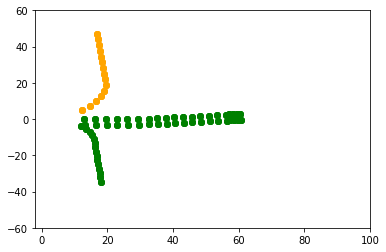

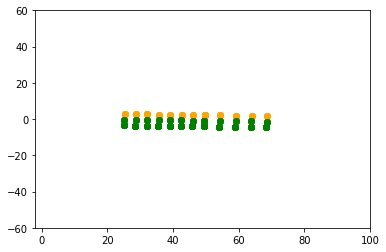

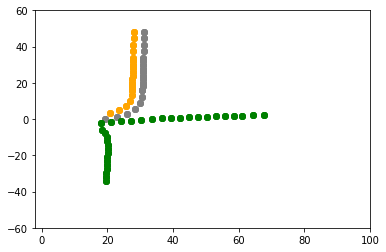

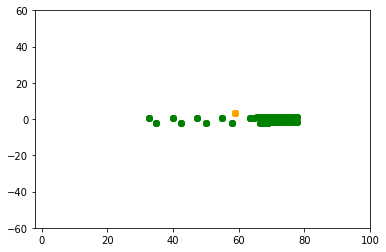

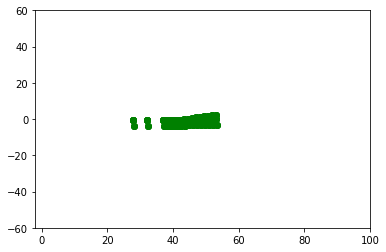

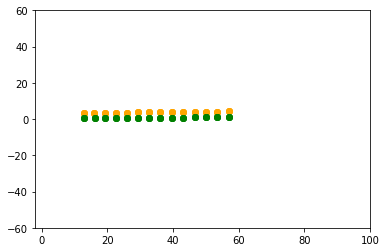

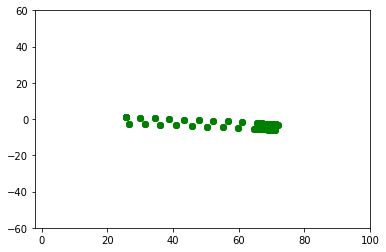

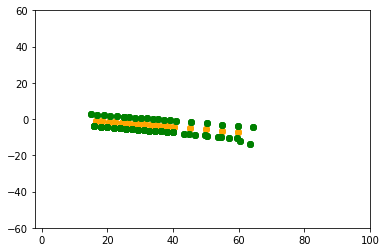

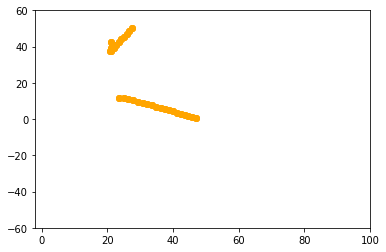

KeyboardInterrupt: 

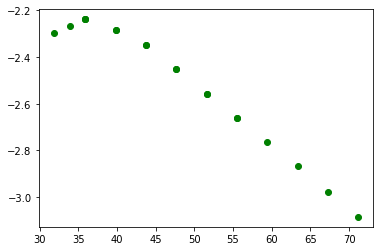

In [63]:
print(len(total_centerlines))
for i in range(10):
#     print(len(total_centerlines[i]))
    for j in range(5):
#         print(len(total_centerlines[i][j]))
        for traj in total_centerlines[i][j]:
            for ind in range(len(traj)):
                plt.scatter(traj[ind][0], traj[ind][1], color = colors[j])
    plt.xlim([-2, 100])
    plt.ylim([-60, 60])
#     plt.axis('equal')
    plt.show()
    plt.clf()

In [32]:
np.save("./data_augmented.npy", np.array(data_augmented))

In [40]:
np.load("./data_augmented.npy", allow_pickle=True)

(49, 2)

In [ ]:
   
    for path in left_forks:
        if to_viz: if to_viz: plt.subplot(len(leaves) + 2, 2, cnttt + 3) # row 1, col 2 index 1
        cnttt = cnttt + 1
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            x_plot, y_plot = arr[:, 0], arr[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)

        for lane_cl in lane_centerlines:
            x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)

        for p in path:
            polygon = avm.get_lane_segment_polygon(p, city)
            x_plot, y_plot = polygon[:, 0], polygon[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color=color_modes["left_forks"], zorder=4)
        if to_viz: if to_viz: plt.title("LEFT LANE FORK")
        if to_viz: if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)
        
        centerline = avm.get_lane_segment_centerline(path[1], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
        v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
        psidot_init = (psi_init_1 - psi_init)/0.1
        psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
        var_inp = np.array([cx, cy, psi_fin])
        fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
        var_inp = np.array([cx, cy, psi_fin])

        sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

        tot_time = np.linspace(0.0, t_fin, num)
        tot_time_copy = tot_time.reshape(num, 1)

        P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

        nvar = 11
        x_pred = np.dot(P, sol[:, :nvar].T)
        y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
        x_pred = x_pred.T
        y_pred = y_pred.T                
        if to_viz: if to_viz: plt.scatter(x_pred, y_pred, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.scatter(cx, cy, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
        if to_viz: if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])       
        break
            
    for path in right_forks:
        if to_viz: if to_viz: plt.subplot(5 + 2, 2, cnttt + 3) # row 1, col 2 index 1
        cnttt = cnttt + 1
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            x_plot, y_plot = arr[:, 0], arr[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)

        for lane_cl in lane_centerlines:
            x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)

        for p in path:
            polygon = avm.get_lane_segment_polygon(p, city)
            x_plot, y_plot = polygon[:, 0], polygon[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color=color_modes["right_forks"], zorder=4)            
        if to_viz: if to_viz: plt.title("RIGHT LANE FORK")
        x_traj, y_traj = x_rotated, y_rotated
        if to_viz: if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)
        
        centerline = avm.get_lane_segment_centerline(path[1], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
        v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
        psidot_init = (psi_init_1 - psi_init)/0.1
        psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
        var_inp = np.array([cx, cy, psi_fin])
        fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
        var_inp = np.array([cx, cy, psi_fin])

        sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

        tot_time = np.linspace(0.0, t_fin, num)
        tot_time_copy = tot_time.reshape(num, 1)

        P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

        nvar = 11
        x_pred = np.dot(P, sol[:, :nvar].T)
        y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
        x_pred = x_pred.T
        y_pred = y_pred.T                
        if to_viz: if to_viz: plt.scatter(x_pred, y_pred, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.scatter(cx, cy, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
        if to_viz: if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])       
        break
            
    for path in left_lane_change:
        if to_viz: if to_viz: plt.subplot(5 + 2, 2, cnttt + 3) # row 1, col 2 index 1
        cnttt = cnttt + 1
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            x_plot, y_plot = arr[:, 0], arr[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)

        for lane_cl in lane_centerlines:
            x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)

        for p in path:
            polygon = avm.get_lane_segment_polygon(p, city)
            x_plot, y_plot = polygon[:, 0], polygon[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color=color_modes["left_lane_change"], zorder=4)
        if to_viz: if to_viz: plt.title("LEFT LANE CHANGE")
        x_traj, y_traj = x_rotated, y_rotated
        if to_viz: if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)
        
        centerline = avm.get_lane_segment_centerline(path[1], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
        v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
        psidot_init = (psi_init_1 - psi_init)/0.1
        psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
        var_inp = np.array([cx, cy, psi_fin])
        fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
        var_inp = np.array([cx, cy, psi_fin])

        sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

        tot_time = np.linspace(0.0, t_fin, num)
        tot_time_copy = tot_time.reshape(num, 1)

        P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

        nvar = 11
        x_pred = np.dot(P, sol[:, :nvar].T)
        y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
        x_pred = x_pred.T
        y_pred = y_pred.T                
        if to_viz: if to_viz: plt.scatter(x_pred, y_pred, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.scatter(cx, cy, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
        if to_viz: if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])       
        break
            
    for path in right_lane_change:
        if to_viz: if to_viz: plt.subplot(5 + 2, 2, cnttt + 3) # row 1, col 2 index 1
        cnttt = cnttt + 1
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            x_plot, y_plot = arr[:, 0], arr[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)

        for lane_cl in lane_centerlines:
            x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)

        for p in path:
            polygon = avm.get_lane_segment_polygon(p, city)
            x_plot, y_plot = polygon[:, 0], polygon[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color=color_modes["right_lane_change"], zorder=4)
        if to_viz: if to_viz: plt.title("RIGHT LANE CHANGE")
        x_traj, y_traj = x_rotated, y_rotated
        if to_viz: if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)

        centerline = avm.get_lane_segment_centerline(path[1], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
        v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
        psidot_init = (psi_init_1 - psi_init)/0.1
        psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
        var_inp = np.array([cx, cy, psi_fin])
        fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
        var_inp = np.array([cx, cy, psi_fin])

        sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

        tot_time = np.linspace(0.0, t_fin, num)
        tot_time_copy = tot_time.reshape(num, 1)

        P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

        nvar = 11
        x_pred = np.dot(P, sol[:, :nvar].T)
        y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
        x_pred = x_pred.T
        y_pred = y_pred.T
        if to_viz: if to_viz: plt.scatter(x_pred, y_pred, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.scatter(cx, cy, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
        if to_viz: if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])       
        break
            
    for path in holds:
        if to_viz: if to_viz: plt.subplot(5 + 2, 2, cnttt + 3) # row 1, col 2 index 1
        cnttt = cnttt + 1
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            x_plot, y_plot = arr[:, 0], arr[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color='black', zorder=4)
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, color='white', zorder=4)

        for lane_cl in lane_centerlines:
            x_plot, y_plot = lane_cl[:, 0], lane_cl[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)        
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, "--", color="white", alpha=1, linewidth=1.5, zorder=4)
            
        for p in path:
            polygon = avm.get_lane_segment_polygon(p, city)
            x_plot, y_plot = polygon[:, 0], polygon[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color=color_modes["holds"], zorder=4)  
        if to_viz: if to_viz: plt.title("KEEP LANE")
        x_traj, y_traj = x_rotated, y_rotated        
        if to_viz: if to_viz: plt.scatter(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='Observed', zorder=5)
        
        
        centerline = avm.get_lane_segment_centerline(path[2], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
        v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
        psidot_init = (psi_init_1 - psi_init)/0.1
        psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
        var_inp = np.array([cx, cy, psi_fin])
        fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
        var_inp = np.array([cx, cy, psi_fin])
        
        sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

        tot_time = np.linspace(0.0, t_fin, num)
        tot_time_copy = tot_time.reshape(num, 1)

        P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

        nvar = 11
        x_pred = np.dot(P, sol[:, :nvar].T)
        y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
        x_pred = x_pred.T
        y_pred = y_pred.T             
        if to_viz: if to_viz: plt.scatter(x_pred, y_pred, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.scatter(cx, cy, color='yellow', label='GT', zorder=5)
        if to_viz: if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
        if to_viz: if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])       
        break







    colors = ["grey", "blue", "orange", "green", "green", "green"]
    seq = []
    left_forks = []
    right_forks = []
    left_lane_change = []
    right_lane_change = []
    holds = []
    init_len = len(trajs)
    for leafno, leaf in enumerate(leaves):
        # go above
        cnttt = 0
        lane_id = leaf
        path = []
        if to_viz: if to_viz: plt.subplot(len(leaves)/2 + 2, 2, leafno + 3) # row 1, col 2 index 1
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            x_plot, y_plot = arr[:, 0], arr[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.plot(x_plot, y_plot, color='black', zorder=4)        
        while paths.get(lane_id) != None and cnttt < 100:
            cnttt = cnttt + 1
            polygon = avm.get_lane_segment_polygon(lane_id, city)
            x_plot, y_plot = polygon[:, 0], polygon[:, 1]
            x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
            if to_viz: if to_viz: plt.fill(x_plot, y_plot, color=colors[cnttt-1], zorder=5)                    
            path.append(lane_id)
            if paths.get(lane_id) != None:
                lane_id = paths[lane_id]
        seq.append(path)
        if len(path) == 0: continue
        if to_viz: if to_viz: plt.xlim([x_traj[20] - 50, x_traj[20] + 50])
        if to_viz: if to_viz: plt.ylim([y_traj[20] - 50, y_traj[20] + 50])
        straight = []
        centerline = avm.get_lane_segment_centerline(path[0], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        angle = np.arctan2(cy - y_rotated[20], cx - x_rotated[20]) - np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        if cur in path:
            if angle > np.pi/3:
                left_forks.append(path)
                if to_viz: if to_viz: plt.title("Left fork: {}".format(len(left_forks)))
            elif angle < -np.pi/3:
                right_forks.append(path)
                if to_viz: if to_viz: plt.title("Right fork: {}".format(len(right_forks)))
            else:
                holds.append(path)
                if to_viz: if to_viz: plt.title("Straight")
        else:
            if angle > 0:
                left_lane_change.append(path)
                if to_viz: if to_viz: plt.title("Left lane change: {}".format(len(left_lane_change)))
            else:
                right_lane_change.append(path)
                if to_viz: if to_viz: plt.title("Right lane change: {}".format(len(right_lane_change)))
        if to_viz: if to_viz: plt.plot(x_plot, y_plot, color="red", zorder=11)
#         if to_viz: if to_viz: plt.scatter(x_plot[-1], y_plot[-1], color="red", zorder=11)
        if to_viz: if to_viz: plt.scatter(cx, cy, color="red", zorder=11)
        centerline = avm.get_lane_segment_centerline(path[1], city)
        x_plot, y_plot = centerline[:, 0], centerline[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        cx, cy = x_plot[-1], y_plot[-1]
        psi_init = np.arctan2(y_rotated[20] - y_rotated[19], x_rotated[20] - x_rotated[19])
        psi_init_1 = np.arctan2(y_rotated[19] - y_rotated[18], x_rotated[19] - x_rotated[18])
        v_init = ((y_rotated[20] - y_rotated[19])/0.1)**0.5 + ((x_rotated[20] - x_rotated[19])/0.1)**0.5
        psidot_init = (psi_init_1 - psi_init)/0.1
        psi_fin = np.arctan2(y_plot[-1] - y_plot[-2], x_plot[-1] - x_plot[-2])
        var_inp = np.array([cx, cy, psi_fin])
        fixed_params = np.array([x_rotated[20], y_rotated[20], 0, psi_init, psidot_init])
        var_inp = np.array([cx, cy, psi_fin])

        sol, _ = problem.solve(fixed_params.reshape(1,5), var_inp.reshape(1,3))

        tot_time = np.linspace(0.0, t_fin, num)
        tot_time_copy = tot_time.reshape(num, 1)

        P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)

        nvar = 11
        x_pred = np.dot(P, sol[:, :nvar].T)
        y_pred = np.dot(P, sol[:, nvar:2*nvar].T)
        x_pred = x_pred.T
        y_pred = y_pred.T
        if to_viz: if to_viz: plt.scatter(x_pred, y_pred, color='yellow', zorder=12)
        
        if to_viz: if to_viz: plt.scatter(cx, cy, color="red", zorder=11)
        if abs(angle + np.pi) > 0.3:
            x_final = np.concatenate((x_rotated[:20], x_pred[0]))
            y_final = np.concatenate((y_rotated[:20], y_pred[0]))
#             trajs.append(np.concatenate((x_final.reshape(50, 1), y_final.reshape(50, 1)), axis=1))


In [71]:
np.save("./trajs.npy", trajs)
np.save("./nums.npy", numss)

In [76]:
np.load("trajs.npy").shape

(128, 50, 2)

In [75]:
np.load("/home/vikrant/datasets/datasets/argoverse/val_data.npy", allow_pickle=True).shape

(39472, 50, 2)

  0%|          | 1/39472 [06:09<4051:18:45, 369.50s/it]

minADE: 0.4258934548641691 	 its FDE: 0.9889703918838241
minFDE=	 0.9889703918838241 	 its ADE: 0.4258934548641691

  0%|          | 2/39472 [10:44<3440:05:01, 313.76s/it]

minADE: 0.7550370278416828 	 its FDE: 3.922255747006337
minFDE=	 0.5002159748128725 	 its ADE: 1.0444518112679326

  0%|          | 3/39472 [17:14<3822:01:45, 348.61s/it]

minADE: 0.5182444175745381 	 its FDE: 1.7380833808283735
minFDE=	 1.4521290044779713 	 its ADE: 1.7151177557363828

  0%|          | 4/39472 [22:32<3691:29:57, 336.71s/it]

minADE: 0.602015777518362 	 its FDE: 3.517242067241827
minFDE=	 2.1252089681786686 	 its ADE: 2.297018631320792

  0%|          | 5/39472 [28:34<3790:18:32, 345.73s/it]

minADE: 1.584734167174641 	 its FDE: 1.491630457649673
minFDE=	 0.5125996640157087 	 its ADE: 2.3940883158130006

  0%|          | 6/39472 [31:14<3097:05:07, 282.51s/it]

minADE: 0.6121237482833498 	 its FDE: 1.6073118693737594
minFDE=	 1.6073118693737594 	 its ADE: 0.6121237482833498

  0%|          | 7/39472 [34:27<2777:13:28, 253.34s/it]

minADE: 1.0833201895141813 	 its FDE: 1.0796598375413216
minFDE=	 1.0796598375413216 	 its ADE: 1.0833201895141813

  0%|          | 8/39472 [40:54<3244:52:22, 296.01s/it]

minADE: 0.5078707759119808 	 its FDE: 2.5169758028047577
minFDE=	 0.78216968571277 	 its ADE: 0.8243066241439271
